In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torchvision
from torchvision import datasets, transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
import timm
import cv2
import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from pathlib import Path
from sklearn.model_selection import train_test_split
from albumentations.core.transforms_interface import DualTransform

from efficientnet_pytorch import EfficientNet

from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
from PIL import Image, ImageOps, ImageEnhance

In [2]:
torchvision.__version__, torch.__version__ # ('0.11.2+cu111', '1.10.0+cu111')

('0.11.2+cu111', '1.10.1+cu111')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [5]:
class CFG:

  epochs =20                              # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  BATCH_SIZE = 50
  N_EPOCHS = 30                        # Batch Size for Dataset

#   model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  IMG=224
  img_size = (IMG,IMG)                        # Resize all the images to be 224 by 224
  
  # going to be used for loading dataset
  ds_path = "/root/meidai/data/imgB/ABC20220706-1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device on which we are:{}".format(device))

device on which we are:cuda


In [6]:
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [7]:
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)

GridMask

In [8]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

AugMax


In [9]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image

In [10]:


import albumentations
import albumentations.pytorch

In [11]:
train_transformer = albumentations.Compose([
    albumentations.Resize(224,224),
    albumentations.OneOf([
        GridMask(num_grid=1, mode=0.2, rotate=0),
        GridMask(num_grid=2, mode=0.3, rotate=0),
    ], p=0.2),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.pytorch.ToTensorV2()
    # RandomAugMix(severity=4, width=3, alpha=1.0, p=0.2)
])

test_transformer=albumentations.Compose([
    albumentations.Resize(224,224),
    albumentations.pytorch.ToTensorV2()
    # RandomAugMix(severity=4, width=3, alpha=1.0, p=0.2)
])

In [12]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform:
            res = self.transform(image=img)
            img = res['image']
        else:
            img = img

        return (img, label)

In [13]:
train=Dataset(train_dir,train_transformer)
test=Dataset(test_dir,test_transformer)

In [14]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [15]:
train_loader=DataLoader(train,batch_size=CFG.BATCH_SIZE,num_workers=16)
test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=16)


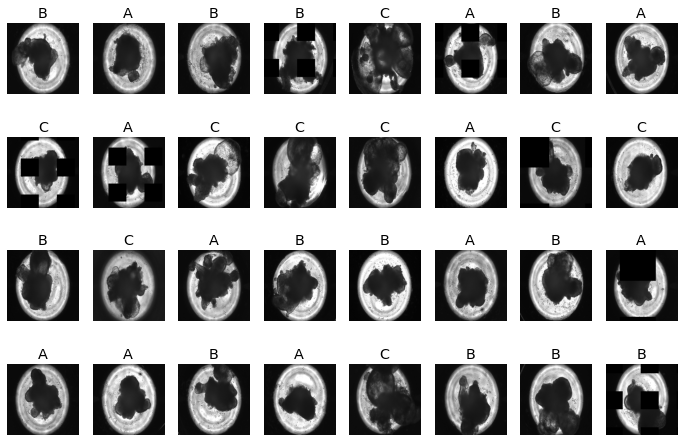

In [16]:
train_loader = torch.utils.data.DataLoader(dataset =train, batch_size = 36, shuffle=False)
samples, label = iter(train_loader).next()
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

ad = {0:'A', 1:'B',2:'C'}

for num, sample in enumerate(samples[:32]):
    plt.subplot(4,8,num+1)
    plt.title(ad[label[num].item()])
    plt.axis('off')
    sample = sample.cpu()
    plt.imshow(sample.permute(1, 2, 0))

In [17]:
torch.backends.cudnn.benchmark = True

In [18]:
### Obtained from Paper ###
# Configs taken from 
# https://github.com/leondgarse/keras_efficientnet_v2/blob/main/keras_efficientnet_v2/efficientnet_v2.py
# convs parameter is which type of block to use, maps to `layer_map`
# 6 models are supported, more are coming soon.
CONFIGS = {
    "b0": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [1, 2, 2, 3, 5, 8],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights": "tf_efficientnetv2_b0",
    },
    "b1": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [2, 3, 3, 4, 6, 9],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs":[0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_b1",
    },
    "b2": {
        "widths": [32, 16, 32, 56, 104, 120, 208],
        "depths": [2, 3, 3, 4, 6, 10],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1408,
        "timm_weights":"tf_efficientnetv2_b2",
    },
    "s": {
        "widths": [24, 24, 48, 64, 128, 160, 256],
        "depths": [2, 4, 4, 6, 9, 15],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights": "tf_efficientnetv2_s"
    },
    "m": {
        "widths": [24, 24, 48, 80, 160, 176, 304, 512],
        "depths": [3, 5, 5, 7, 14, 18, 5],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_m",
    },
    "l": {
        "widths": [32, 32, 64, 96, 192, 224, 384, 640],
        "depths": [4, 7, 7, 10, 19, 25, 7],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_l",
    }
}

In [19]:
def conv_block(in_channels, out_channels, kernel_size=3, 
               stride=1, padding=1, groups=1,
               bias=False, bn=True, act = True):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, 
                  padding=padding, groups=groups, bias=bias),
        nn.BatchNorm2d(out_channels) if bn else nn.Identity(),
        nn.SiLU() if act else nn.Identity()
    ]
    return nn.Sequential(*layers)

In [20]:
4//1

4

In [21]:
class SEBlock(nn.Module):
    def __init__(self, c, r=24):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveMaxPool2d(1)
        self.excitation = nn.Sequential(
            nn.Conv2d(c, c // r, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(c // r, c, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        s = self.squeeze(x)
        e = self.excitation(s)
        return x * e

In [22]:
class MBConv(nn.Module):
    def __init__(self, n_in, n_out, expansion, kernel_size=3, stride=1, r=24, dropout=0.1):
        super(MBConv, self).__init__()
        self.skip_connection = (n_in == n_out) and (stride == 1)
        
        padding = (kernel_size-1)//2
        expanded = expansion*n_in
        
        self.expand_pw = nn.Identity() if expansion == 1 else conv_block(n_in, expanded, kernel_size=1, padding=0)
        self.depthwise = conv_block(expanded, expanded, kernel_size=kernel_size, 
                                    stride=stride, padding=padding, groups=expanded)
        self.se = SEBlock(expanded, r=4 * expansion)
        self.reduce_pw = conv_block(expanded, n_out, kernel_size=1, padding=0, act=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.expand_pw(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.reduce_pw(x)
        if self.skip_connection:
            x = self.dropout(x)
            x = x + residual
        return x

In [23]:
class FusedMBConv(nn.Module):
    def __init__(self, n_in, n_out, expansion, kernel_size=3, stride=1, r=24, dropout=0.1):
        super(FusedMBConv, self).__init__()
        self.skip_connection = (n_in == n_out) and (stride == 1)
        padding = (kernel_size-1)//2
        expanded = expansion*n_in
        
        self.expand_pw = conv_block(n_in, expanded, kernel_size=3, stride=stride, padding=1)
        self.reduce_pw = conv_block(expanded, n_out, kernel_size=1, padding=0, act=False)
        
        if expansion == 1:
            self.reduce_pw = nn.Identity() # for consistency with timm implementation
            self.expand_pw = conv_block(n_in, n_out, kernel_size=3, stride=stride, padding=1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.expand_pw(x)
        x = self.reduce_pw(x)
        if self.skip_connection:
            x = self.dropout(x)
            x = x + residual
        return x

In [24]:
def mbconv4(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return MBConv(n_in, n_out, 4, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def mbconv6(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return MBConv(n_in, n_out, 6, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def fused_mbconv1(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return FusedMBConv(n_in, n_out, 1, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def fused_mbconv4(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return FusedMBConv(n_in, n_out, 4, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
layers_map = [fused_mbconv1, fused_mbconv4, mbconv4, mbconv6]

In [25]:
def create_stage(n_in, n_out, num_layers, layer=mbconv6, 
                 kernel_size=3, stride=1, r=24, ps=0):
    layers = [layer(n_in, n_out, kernel_size=kernel_size,
                       stride=stride, r=r, dropout=ps)]
    layers += [layer(n_out, n_out, kernel_size=kernel_size,
                        r=r, dropout=ps) for _ in range(num_layers-1)]
    return nn.Sequential(*layers)

In [26]:
class EfficientNetV2(nn.Module):
    """
    Generic EfficientNet V2 Class.
    """
    def __init__(self, cfg, n_classes=3):
        super(EfficientNetV2, self).__init__()
        self.cfg = cfg
        self.n_classes = n_classes
        widths, depths, strides, convs = cfg['widths'],cfg['depths'],cfg['strides'],cfg['convs']
        outconv_size = cfg['output_conv_size']
        
        stages = [conv_block(3, widths[0], stride=2, padding=1)]
        for i in range(len(depths)):
            stages.append(create_stage(widths[i], widths[i + 1], depths[i], layer=layers_map[convs[i]], 
                        stride=strides[i], r=4 if i ==0 else 24, ps=0))

        self.features = nn.Sequential(*stages)
        self.pre = conv_block(widths[-1], outconv_size, kernel_size=1, padding=0)
        self.pool_flatten = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten())
        self.head = nn.Sequential(
            nn.Linear(outconv_size, n_classes)
        )
            
    def forward(self, x):
        x = self.features(x)
        x = self.pre(x)
        x = self.pool_flatten(x)
        x = self.head(x)
        return x

In [27]:
def efficientnetv2_b0(n_classes=3):
    return EfficientNetV2(CONFIGS['b0'], n_classes=n_classes)
def efficientnetv2_b1(n_classes=3):
    return EfficientNetV2(CONFIGS['b1'], n_classes=n_classes)
def efficientnetv2_b2(n_classes=3):
    return EfficientNetV2(CONFIGS['b2'], n_classes=n_classes)
def efficientnetv2_s(n_classes=3):
    return EfficientNetV2(CONFIGS['s'], n_classes=n_classes)
def efficientnetv2_m(n_classes=3):
    return EfficientNetV2(CONFIGS['m'], n_classes=n_classes)
def efficientnetv2_l(n_classes=3):
    return EfficientNetV2(CONFIGS['l'], n_classes=n_classes)

In [28]:
classes=['A','B','C']

In [29]:
def load_timm_weights(model):
    url = model.cfg.get("timm_weights")
    timm_model = timm.create_model(url, pretrained=True, num_classes=len(classes))
    params = nn.utils.parameters_to_vector(timm_model.parameters())
    nn.utils.vector_to_parameters(params, model.parameters())

In [30]:
model = efficientnetv2_s(n_classes=len(classes))
load_timm_weights(model)
for param in model.parameters():
    param.requires_grad = False
    
n_inputs = model.head[0].in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs,512),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model.load_state_dict(torch.load('/root/meidai/pragram/pytorch/code/Effinet/Eff2_kfold2_Gridmask/weights/model_5e_0.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

EfficientNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (1): Sequential(
      (0): FusedMBConv(
        (expand_pw): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
        (reduce_pw): Identity()
        (dropout): Dropout(p=0, inplace=False)
      )
      (1): FusedMBConv(
        (expand_pw): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
        (reduce_pw): Identity()
        (dropout): Dropout(p=0, inplace=

In [31]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [32]:
def test_eval(model):
  test_loss = 0.0
  correct_num=0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()
  test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=25)

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda().float(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      correct_num+=torch.sum(correct_tensor)
      for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
  test_acc=correct_num/len(test_loader.dataset)
  print('Test acc: {:.6f}\n'.format(test_acc))
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [33]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
# optimizer = optim.SGD(model.parameters(), 0.01,
#                                 momentum=0.9,
#                                 weight_decay=1e-5)
# optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

In [34]:
from tqdm import tqdm
import time
import copy
train_loader=DataLoader(train,batch_size=CFG.BATCH_SIZE,num_workers=16)
test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=16)

In [35]:
for i in range(5):
    model.load_state_dict(torch.load(f'./weights2(acc_69)/model_5e_{i}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    test_eval(model)

100%|██████████| 6/6 [00:03<00:00,  2.00it/s]


Test acc: 0.700000

Test Loss: 0.726330

Test Accuracy of     A: 76% (76/100)
Test Accuracy of     B: 52% (52/100)
Test Accuracy of     C: 82% (82/100)

Test Accuracy (Overall): 70.0000 (210.0/300.0)


100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Test acc: 0.690000

Test Loss: 0.689006

Test Accuracy of     A: 75% (75/100)
Test Accuracy of     B: 56% (56/100)
Test Accuracy of     C: 76% (76/100)

Test Accuracy (Overall): 69.0000 (207.0/300.0)


100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Test acc: 0.686667

Test Loss: 0.716290

Test Accuracy of     A: 65% (65/100)
Test Accuracy of     B: 60% (60/100)
Test Accuracy of     C: 81% (81/100)

Test Accuracy (Overall): 68.6667 (206.0/300.0)


100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Test acc: 0.680000

Test Loss: 1.056554

Test Accuracy of     A: 60% (60/100)
Test Accuracy of     B: 62% (62/100)
Test Accuracy of     C: 82% (82/100)

Test Accuracy (Overall): 68.0000 (204.0/300.0)


100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

Test acc: 0.690000

Test Loss: 1.061829

Test Accuracy of     A: 63% (63/100)
Test Accuracy of     B: 62% (62/100)
Test Accuracy of     C: 82% (82/100)

Test Accuracy (Overall): 69.0000 (207.0/300.0)


In [36]:
models=[]
for i in range(5):
    model.load_state_dict(torch.load(f'./weights2(acc_69)/model_5e_{i}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    models.append(model)

In [37]:
def get_all_preds_k_fold(models,loader):
  all_preds=torch.tensor([])
  ground_truth=torch.tensor([])
  running_loss=0
  model1=models[0]
  model2=models[1]
  model3=models[2]
  model4=models[3]
  model5=models[4]
  for batch in loader:
    images,labels=batch
    images=images.to(device).float()
    labels=labels.to('cpu')

    ground_truth=torch.cat((ground_truth,labels),dim=0)
    p1=model1(images).to('cpu')
    p2=model2(images).to('cpu')
    p3=model3(images).to('cpu')
    p4=model4(images).to('cpu')
    p5=model5(images).to('cpu')
    preds=(p1+p2+p3+p4+p5)/5

    all_preds=torch.cat((all_preds,preds),dim=0)
    loss_val = criterion(preds, labels)
    running_loss += loss_val.item() * images.size(0)
  
  loss=running_loss/len(loader)
  return all_preds,ground_truth,loss

In [38]:
torch.cuda.empty_cache()

In [39]:
with torch.no_grad():
      prediction_loader=torch.utils.data.DataLoader(test,batch_size=int(len(test)/300),num_workers=8)
      test_preds,ground_truth,loss=get_all_preds_k_fold(models,prediction_loader)

In [40]:
def get_num_correct(preds,labels):
  print(preds.argmax(dim=1).eq(labels).sum().item()/len(preds))

In [41]:
get_num_correct(test_preds,ground_truth)

0.69


In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ground_truth,test_preds.argmax(dim=1))
print(type(cm))

<class 'numpy.ndarray'>


In [43]:

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),fontsize=30, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


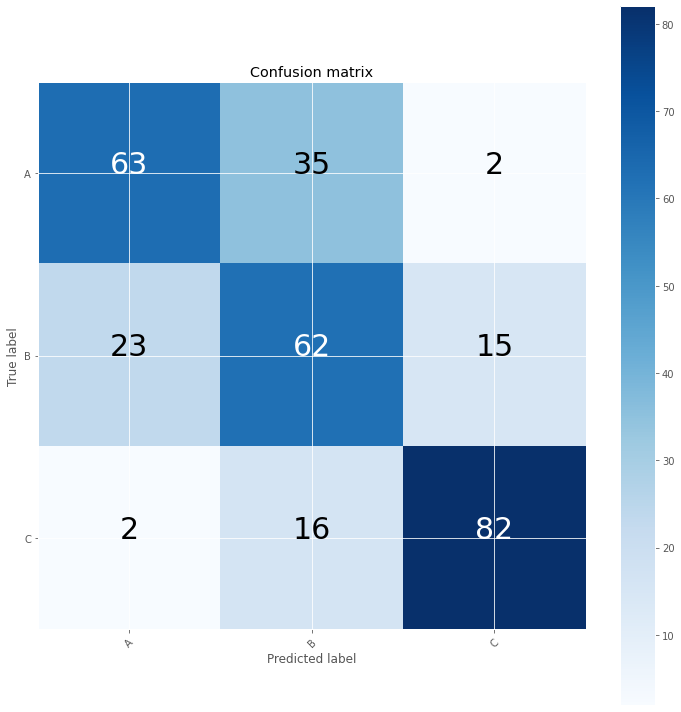

In [44]:
names=('A','B','C')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

Vitとeffinetのアンサンブル

In [45]:
prediction=test_preds.argmax(dim=1)
testY=ground_truth
lst_predict = prediction.to('cpu').detach().tolist().copy()
lst_testY = testY.to('cpu').detach().tolist().copy()

In [46]:
m = nn.Softmax(dim=1)
soft_preds=m(test_preds)
soft_preds=m(test_preds)
soft_preds

tensor([[8.2982e-01, 1.6559e-01, 4.5945e-03],
        [1.8971e-06, 6.9764e-05, 9.9993e-01],
        [2.2330e-02, 7.9632e-01, 1.8135e-01],
        [1.3603e-03, 7.9609e-01, 2.0255e-01],
        [2.7629e-01, 7.2327e-01, 4.4505e-04],
        [7.2263e-01, 2.7393e-01, 3.4406e-03],
        [1.3543e-02, 9.1787e-01, 6.8590e-02],
        [9.3265e-05, 8.9454e-04, 9.9901e-01],
        [1.5969e-02, 9.8348e-01, 5.5120e-04],
        [1.2537e-02, 2.4454e-01, 7.4293e-01],
        [7.3231e-03, 5.7065e-01, 4.2202e-01],
        [9.0624e-01, 9.3396e-02, 3.6778e-04],
        [6.4912e-02, 9.3390e-01, 1.1889e-03],
        [6.5312e-04, 9.9839e-01, 9.5868e-04],
        [4.9911e-01, 4.9362e-01, 7.2792e-03],
        [4.2624e-01, 5.6089e-01, 1.2868e-02],
        [8.9472e-06, 1.3974e-04, 9.9985e-01],
        [1.8369e-02, 9.1126e-01, 7.0370e-02],
        [4.0745e-03, 9.4167e-01, 5.4258e-02],
        [2.3858e-02, 6.3579e-01, 3.4036e-01],
        [1.0028e-06, 8.4211e-05, 9.9991e-01],
        [9.3606e-03, 2.8375e-01, 7

In [47]:
vit_prob=torch.load('/root/meidai/pragram/pytorch/code/ViT/ViT6_8_1_1/test_data300VIT6_minimun_loss__in_each_epoch/probability_vit.pt')

In [48]:
vit_prob
vit_label=vit_prob.argmax(dim=1)

In [49]:
ensemble_prob=vit_prob/2+soft_preds/2

In [50]:
ensemble_prob[0],vit_prob[0],soft_preds[0]

(tensor([0.8260, 0.1637, 0.0103]),
 tensor([0.8223, 0.1617, 0.0160]),
 tensor([0.8298, 0.1656, 0.0046]))

In [51]:
ensemble_prob[10],vit_prob[10],soft_preds[10]

(tensor([0.0042, 0.3504, 0.6454]),
 tensor([0.0011, 0.1302, 0.8687]),
 tensor([0.0073, 0.5707, 0.4220]))

In [52]:
ensemble_preds=ensemble_prob.argmax(dim=1)

In [53]:
ensemble_preds

tensor([0, 2, 1, 1, 1, 0, 1, 2, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2,
        2, 2, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 0, 2, 2, 1, 1,
        1, 0, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 2, 0, 1, 1, 1, 2,
        2, 2, 1, 1, 0, 2, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 0, 1, 0, 1, 1, 2, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 2, 0, 0,
        0, 1, 0, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 2, 1, 0,
        0, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2,
        2, 1, 1, 0, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 2, 0, 1, 2, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 1, 2, 1, 1, 1, 1,
        2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 2, 0, 2,
        1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 1, 2, 2, 1, 0, 2, 1, 0, 1, 0, 1, 0, 2, 0,
        1, 1, 2, 0, 0, 1, 1, 2, 2, 2, 2, 1, 2, 0, 0, 2, 1, 1, 1, 0, 2, 2, 2, 2,
        0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 2,

<class 'numpy.ndarray'>
Confusion matrix, without normalization


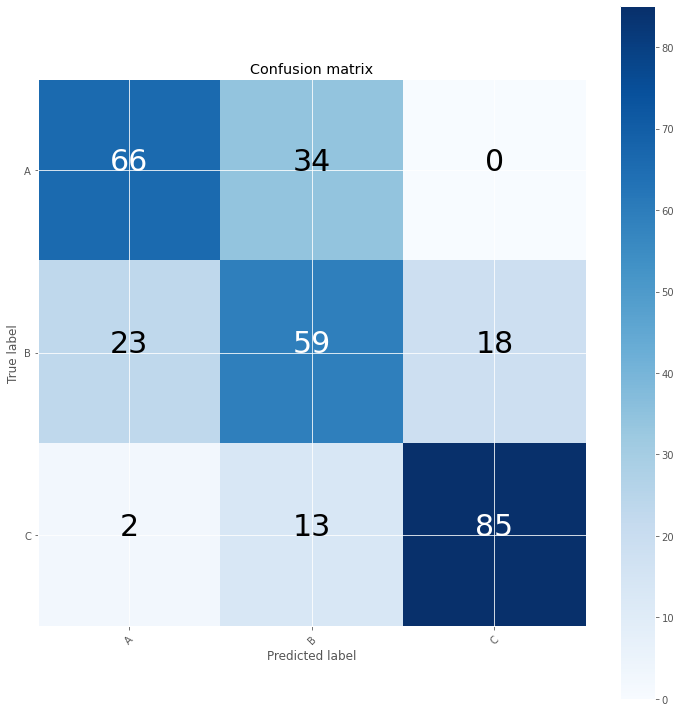

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ground_truth,ensemble_preds)
print(type(cm))
names=('A','B','C')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

In [55]:
get_num_correct(ensemble_prob,ground_truth)

0.7


In [56]:
eff_vit_csv=pd.DataFrame({'effの予測(ラベル)':lst_predict,'effの予測(確率)':soft_preds.to('cpu').detach().tolist().copy(),'vitの予測(ラベル)':vit_label.to('cpu').detach().tolist().copy(),'vitの予測(確率)':vit_prob.to('cpu').detach().tolist().copy(),'eff+vitの平均での予測(ラベル)':ensemble_preds,'eff+vitの平均での予測(確率)':ensemble_prob.detach().tolist().copy()})

In [63]:
eff_vit_csv.to_csv('./eff_vit_ensemble.csv')

In [52]:
# torch.save(ensemble_preds,'/root/meidai/pragram/pytorch/code/Effinet_ViT_sync_rate/vit_eff_predict.pt')

In [69]:
C_dir=[]
C_prob=[]
for idx,dir in enumerate(test_dir):
    if ensemble_preds[idx]==2:
        C_dir.append(dir[37:])
        C_prob.append(ensemble_prob[idx].tolist())


In [70]:
C_dir,C_prob

(['C/h73.37.tif',
  'C/h73.39.tif',
  'B/h49.17.tif',
  'C/h37.34.tif',
  'C/m3.1.57.tif',
  'B/h30.46.tif',
  'C/h73.06.tif',
  'C/h74.54.tif',
  'C/h37.59.tif',
  'B/h41.32.tif',
  'C/h50.55.tif',
  'C/h62.05.tif',
  'C/h32.16.tif',
  'C/m2.2.52.tif',
  'C/h53.47.tif',
  'C/m2.2.59.tif',
  'C/h28.24.tif',
  'C/h29.17.tif',
  'C/h94.52.tif',
  'C/h48.45.tif',
  'B/m111.2.55.tif',
  'C/h39.24.tif',
  'C/m3.1.29.tif',
  'C/m3.2.34.tif',
  'B/h47.35.tif',
  'C/h62.48.tif',
  'C/m3.1.43.tif',
  'C/h30.04.tif',
  'C/m3.2.19.tif',
  'C/h73.40.tif',
  'C/m3.1.12.tif',
  'C/h94.48.tif',
  'C/h64.42.tif',
  'C/h74.60.tif',
  'C/h94.21.tif',
  'C/m2.2.48.tif',
  'C/h72.24.tif',
  'C/h44.21.tif',
  'C/m1.2.13.tif',
  'B/h30.05.tif',
  'C/h62.28.tif',
  'B/h39.18.tif',
  'C/m3.2.48.tif',
  'C/h54.56.tif',
  'C/m112.1.37.tif',
  'C/m3.1.30.tif',
  'C/h74.23.tif',
  'C/m3.2.46.tif',
  'C/m3.1.54.tif',
  'C/m113.2.06.tif',
  'C/h49.60.tif',
  'C/h30.30.tif',
  'C/h90.47.tif',
  'C/h29.29.tif',
  'C/

In [67]:
C_csv=pd.DataFrame({'eff+vitの平均でCと判定されたもの':C_dir,'Cと判定されたものの確率':C_prob})

In [68]:
C_csv.to_csv('./eff_vit_detected_as_C.csv')

In [47]:
answer_csv=pd.DataFrame({'真の値':map(int,lst_testY),'effinetによる予測値':prediction})

In [48]:
answer_csv

真の値  effinetによる予測値
0      0              0
1      2              2
2      1              1
3      2              1
4      0              1
..   ...            ...
295    0              1
296    1              0
297    1              2
298    2              2
299    1              2

[300 rows x 2 columns]

In [49]:
answer_csv.to_csv('./ground_truth_vs_prediction_eff.csv')

In [ ]:
prediction=test_preds.argmax(dim=1)
error ={"AB":[],
        "AC":[],
        "BA":[],
        "BC":[],
        "CA":[],
        "CB":[]}

for i in range(len(prediction)):
    if prediction[i]!= ground_truth[i]:
        if (ground_truth[i]==0)and(prediction[i]==1):
            error["AB"].append(test_dir[i])
        elif (ground_truth[i]==0)and(prediction[i]==2):
            error["AC"].append(test_dir[i])
        elif (ground_truth[i]==1)and(prediction[i]==0):
            error["BA"].append(test_dir[i])
        elif (ground_truth[i]==1)and(prediction[i]==2):
            error["BC"].append(test_dir[i])
        elif (ground_truth[i]==2)and(prediction[i]==0):
            error["CA"].append(test_dir[i])
        elif (ground_truth[i]==2)and(prediction[i]==1):
            error["CB"].append(test_dir[i])


In [54]:
import cv2
print(len(error['AB']),
len(error['AC']),
len(error['BA']),
len(error['BC']),
len(error['CA']),
len(error['CB']))


NameError: name 'error' is not defined

In [55]:
for i in error:
    print(error[i])

NameError: name 'error' is not defined

In [99]:
def copy(ABC, dict):
    for path in dict[ABC]:
        img_path = path[39:-3]
        img=cv2.imread(path)
        img = cv2.resize(img,(480,360))
        dir_path='./error_effinet/'+ABC+'/'
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        cv2.imwrite(dir_path+img_path+'.png',img)# c

In [ ]:
for i in error:
    copy(i,error)

In [105]:
import cv2

for idx,path in enumerate(test_dir):
    dir_path='./test_data_tif/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    img=cv2.imread(path)
    # img = cv2.resize(img,(480,360))
    cv2.imwrite(dir_path+path[39:-4]+'-'+str(idx)+'.tif',img)     

In [58]:
loader = transforms.Compose([transforms.Resize(CFG.img_size), transforms.ToTensor()])

def image_loader(image_name):
    img = cv2.imread(image_name)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = test_transformer(image=image)
   
    # image = Variable(image, requires_grad=True)
    # print(image)
    image = image['image'].unsqueeze(0)
    return image.cuda()

m = nn.Softmax(dim=1)

In [78]:
prediction

NameError: name 'prediction' is not defined

In [108]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2
        else:
            label=0

        if self.transform:
            res = self.transform(image=img)
            img = res['image']
        else:
            img = img

        return (img, label)

In [81]:
test_dir[:1]

['/root/meidai/data/imgB/ABC20220706-1/A/m112.2.30.tif']

In [82]:
cell_image_path

'/root/meidai/pragram/pytorch/code/Effinet/Eff2_kfold2_Randomcrop+flip/test_data/0.png'

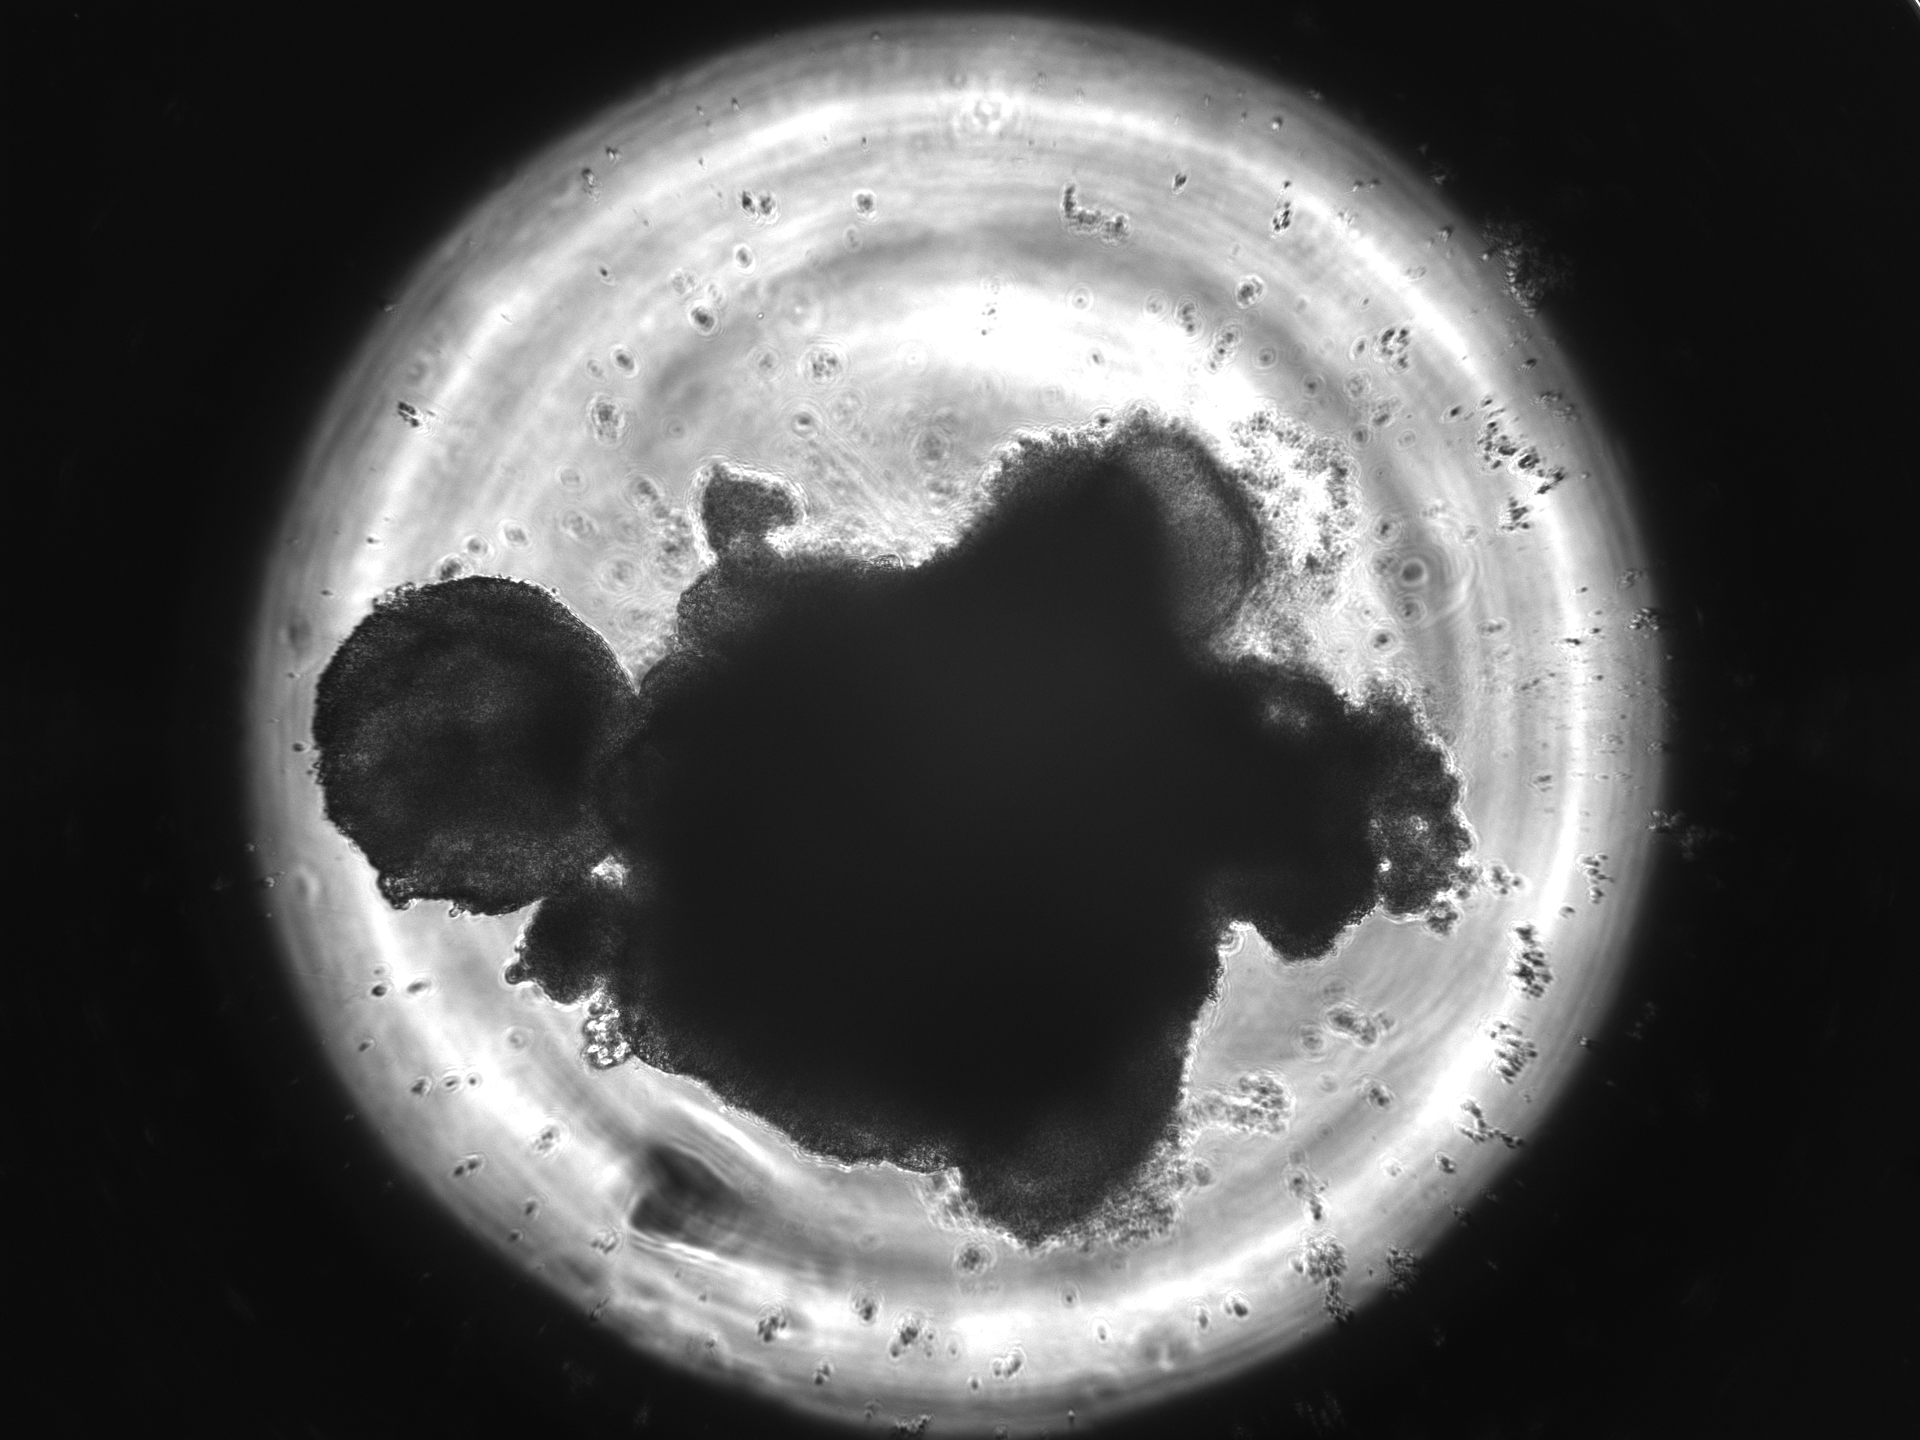

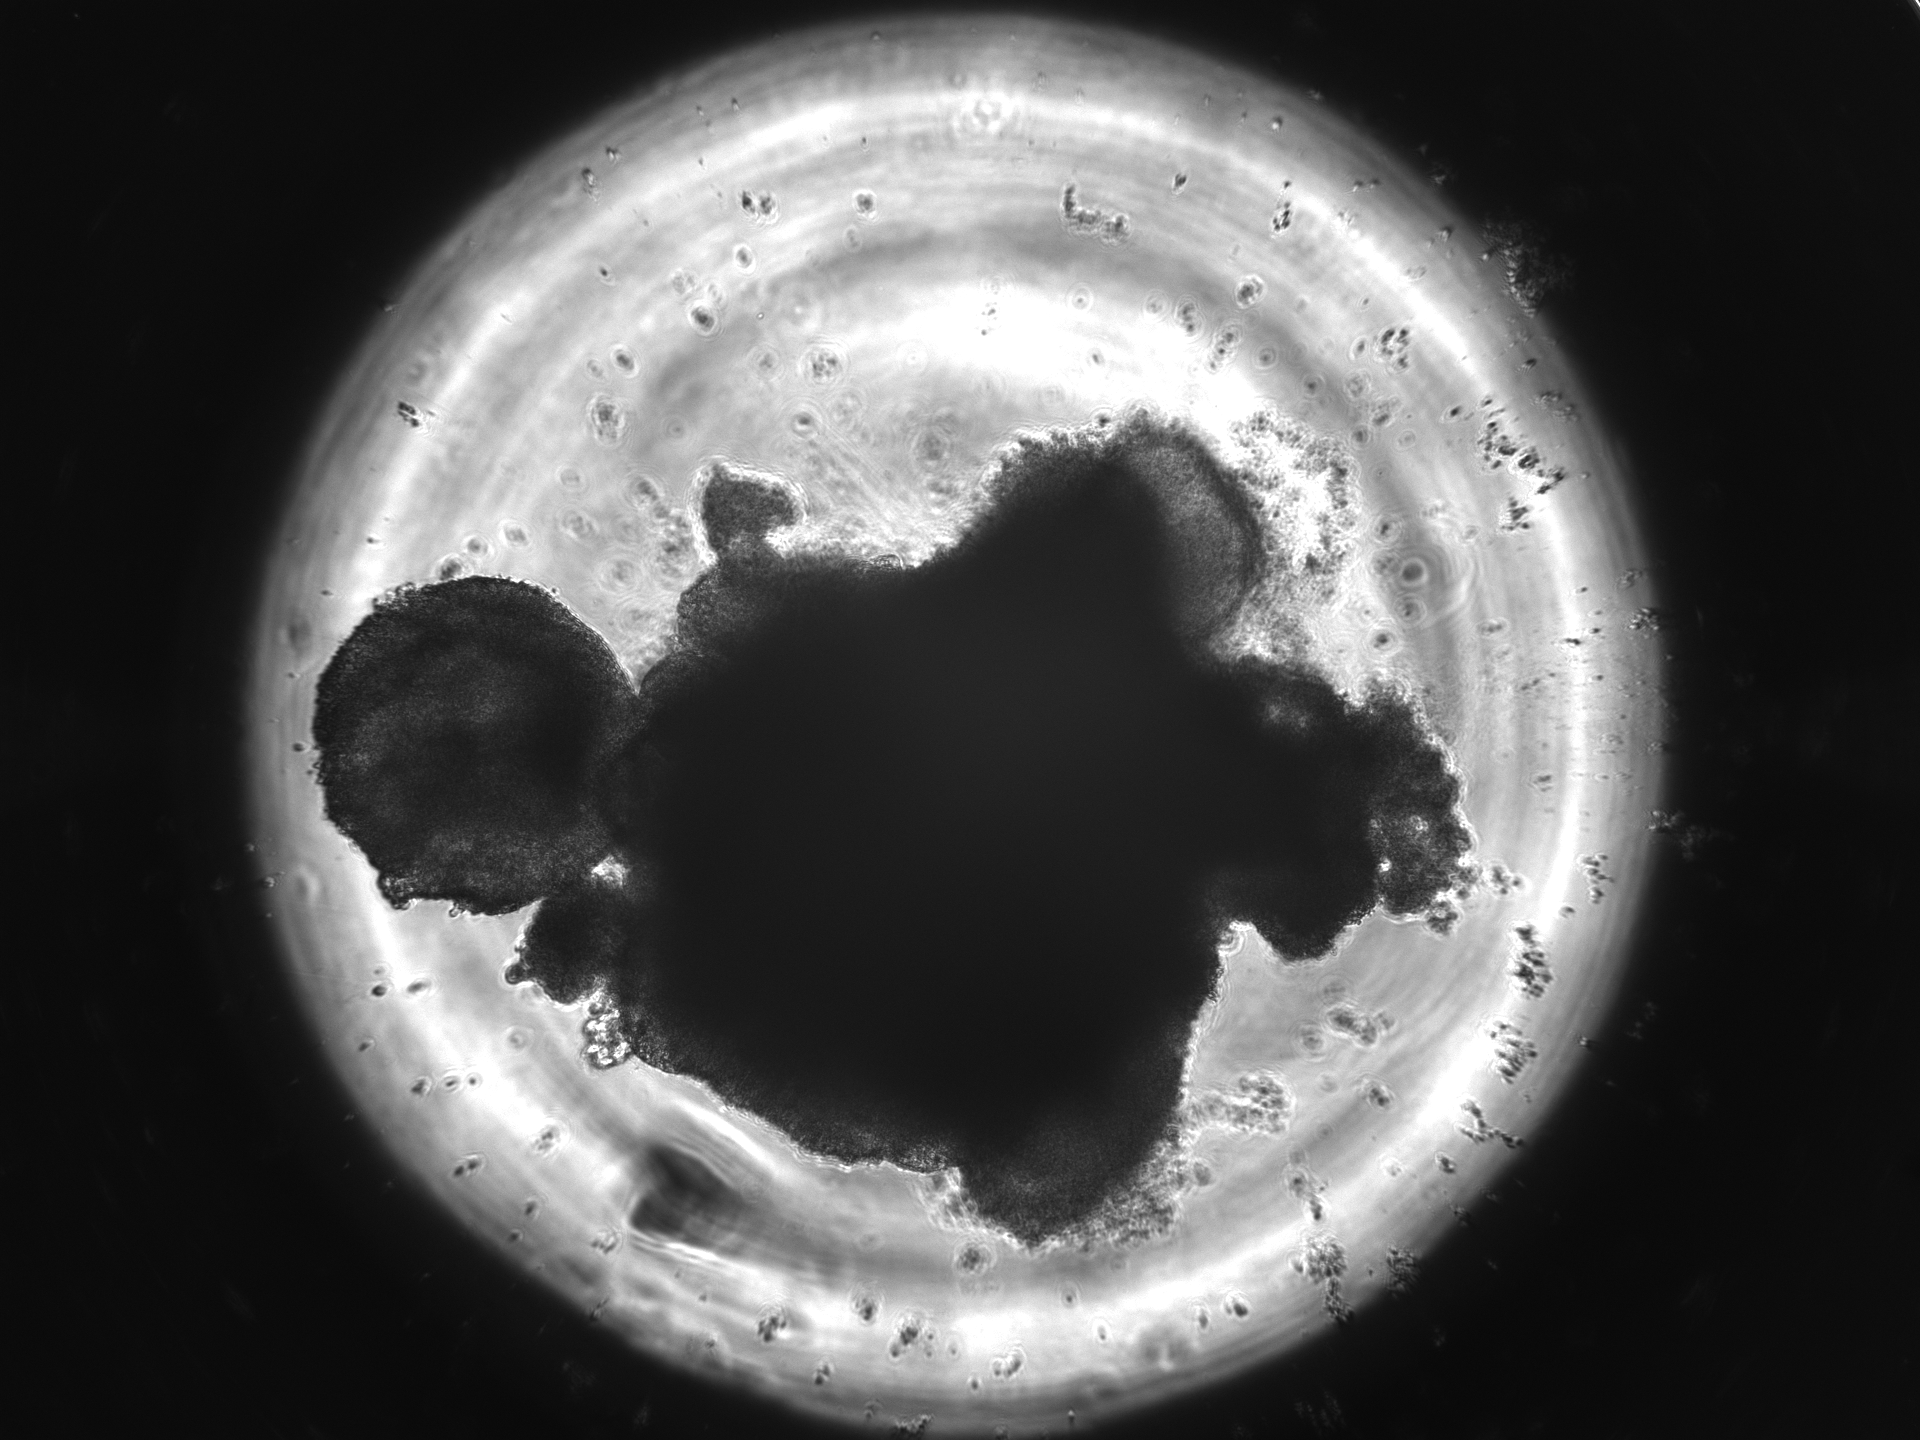

In [101]:
cell_image_path = os.path.join('/root/meidai/pragram/pytorch/code/Effinet/Eff2_kfold2_Randomcrop+flip/test_data', '0.tif')
display(Image.open(cell_image_path))
display(Image.open(test_dir[0]))



In [113]:

cell_image_path = os.path.join('/root/meidai/pragram/pytorch/code/Effinet/Eff2_kfold2_Randomcrop+flip/test_data_png', '2.png')

test1=Dataset([cell_image_path],test_transformer)
with torch.no_grad():
      prediction_loader=torch.utils.data.DataLoader(test1,batch_size=1)
      test_preds1,ground_truth1,loss1=get_all_preds_k_fold(models,prediction_loader)
print(test_preds1,ground_truth1)


tensor([[-1.8729,  1.7015,  0.2223]]) tensor([0.])


In [94]:
test_preds

tensor([[ 2.2929e+00,  6.8393e-01, -2.9009e+00],
        [-5.7075e+00, -2.1032e+00,  7.4679e+00],
        [-1.8729e+00,  1.7015e+00,  2.2227e-01],
        [-3.7211e+00,  2.6538e+00,  1.2835e+00],
        [ 1.8000e+00,  2.7610e+00, -4.6321e+00],
        [ 2.1130e+00,  1.1412e+00, -3.2376e+00],
        [-1.8930e+00,  2.3214e+00, -2.6997e-01],
        [-3.9980e+00, -1.7371e+00,  5.2855e+00],
        [-2.5034e-01,  3.8670e+00, -3.6176e+00],
        [-2.3572e+00,  6.1293e-01,  1.7250e+00],
        [-2.7851e+00,  1.5702e+00,  1.2705e+00],
        [ 3.4174e+00,  1.1463e+00, -4.3917e+00],
        [ 4.5053e-01,  3.1199e+00, -3.5460e+00],
        [-2.4791e+00,  4.8543e+00, -2.0944e+00],
        [ 1.4453e+00,  1.4344e+00, -2.7841e+00],
        [ 1.0873e+00,  1.3611e+00, -2.4123e+00],
        [-4.9385e+00, -2.1895e+00,  6.6845e+00],
        [-1.7039e+00,  2.2030e+00, -3.5122e-01],
        [-2.6135e+00,  2.8318e+00, -2.3370e-02],
        [-1.9722e+00,  1.3118e+00,  6.8389e-01],
        [-6.2069e+00